# Verification

This MMS case verifies the implementation of the Surface Kinetics boundary condition in FESTIM. We will consider a time-dependent case of hydrogen diffusion on domain $\Omega: x\in[0,1] \cup t\in[0, 5]$ with a homogeneous diffusion coefficient $D$, and a Dirichlet boundary condition on the rear domain side.

The problem is:

\begin{align}
    &\dfrac{\partial c_\mathrm{m}}{\partial t} = \nabla\cdot\left(D\nabla c_\mathrm{m} \right) + S \quad \textrm{ on } \Omega, \\
    &-D \nabla c_\mathrm{m} \cdot \mathbf{n} = \lambda_{\mathrm{IS}} \dfrac{\partial c_{\mathrm{m}}}{\partial t} + J_{\mathrm{bs}} - J_{\mathrm{sb}} \quad \textrm{ at } x=0, \\
    &c_\mathrm{m} = c_\mathrm{m, 0} \quad \textrm{ at } x=1, \\
    &c_\mathrm{m} = c_\mathrm{m, 0} \quad \textrm{ at } t=0, \\
    &\dfrac{d c_\mathrm{s}}{d t} = J_{\mathrm{bs}} - J_{\mathrm{sb}} + J_{\mathrm{vs}}  \quad \textrm{ at } x=0, \\
    &c_\mathrm{s}= c_\mathrm{s, 0}\quad \textrm{ at } t=0, \\
\end{align}

with $J_{\mathrm{bs}} = k_{\mathrm{bs}} c_{\mathrm{m}} \lambda_{\mathrm{abs}} \left(1 - \dfrac{c_\mathrm{s}}{n_{\mathrm{surf}}}\right)$, $J_{\mathrm{sb}} = k_{\mathrm{sb}} c_{\mathrm{s}} \left(1 - \dfrac{c_{\mathrm{m}}}{n_\mathrm{IS}}\right)$, $\lambda_{\mathrm{abs}}=n_\mathrm{surf}/n_\mathrm{IS}$.

The manufactured exact solution for mobile concentration is:
\begin{equation*}
c_\mathrm{m, exact}=1+2x^2+x+2t.
\end{equation*}

For this problem, we choose:
\begin{align*}
& k_{\mathrm{bs}}=1/\lambda_{\mathrm{abs}} \\
& k_{\mathrm{sb}}=2/\lambda_{\mathrm{abs}} \\
& n_{\mathrm{IS}} = 20 \\
& n_{\mathrm{surf}} = 5 \\
& D = 5 \\
& \lambda_\mathrm{IS} = 2
\end{align*}

Injecting these parameters and the exact solution for solute H, we obtain:

\begin{align*}
& S = 2(1-2D) \\
& J_{\mathrm{vs}}=2n_\mathrm{surf}\dfrac{2n_\mathrm{IS}+2\lambda_\mathrm{IS}-D}{(2n_\mathrm{IS}-1-2t)^2}+2\lambda_\mathrm{IS}-D \\
& c_\mathrm{s, exact}=n_\mathrm{surf}\dfrac{1+2t+2\lambda_\mathrm{IS}-D}{2n_\mathrm{IS}-1-2t} \\
& c_\mathrm{s,0}=c_\mathrm{s, exact} \\
& c_\mathrm{m,0}=c_\mathrm{m, exact}
\end{align*}

We can then run a FESTIM model with these values and compare the numerical solutions with $c_\mathrm{m, exact}$ and $c_\mathrm{s, exact}$.

In [1]:
import festim as F
import matplotlib.pyplot as plt
import numpy as np

n_IS = 20
n_surf = 5
D = 5
lambda_IS = 2
k_bs = n_IS / n_surf
k_sb = 2 * n_IS / n_surf

solute_source = 2 * (1 - 2 * D)

exact_solution_cm = lambda x, t: 1 + 2 * x**2 + x + 2 * t
exact_solution_cs = (
    lambda t: n_surf * (1 + 2 * t + 2 * lambda_IS - D) / (2 * n_IS - 1 - 2 * t)
)

solute_source = 2 * (1 - 2 * D)


def run_sim(export_times=None):
    # Create the FESTIM model
    my_model = F.Simulation()

    my_model.mesh = F.MeshFromVertices(np.linspace(0, 1, 1000))

    my_model.sources = [F.Source(solute_source, volume=1, field="solute")]

    def J_vs(T, surf_conc, t):
        return (
            2 * n_surf * (2 * n_IS + 2 * lambda_IS - D) / (2 * n_IS - 1 - 2 * t) ** 2
            + 2 * lambda_IS
            - D
        )

    my_model.boundary_conditions = [
        F.DirichletBC(
            surfaces=[2], value=exact_solution_cm(x=F.x, t=F.t), field="solute"
        ),
        F.SurfaceKinetics(
            k_sb=k_sb,
            k_bs=k_bs,
            lambda_IS=lambda_IS,
            n_surf=n_surf,
            n_IS=n_IS,
            J_vs=J_vs,
            surfaces=1,
            initial_condition=exact_solution_cs(t=0),
            t=F.t,
        ),
    ]

    my_model.initial_conditions = [
        F.InitialCondition(field="solute", value=exact_solution_cm(x=F.x, t=F.t))
    ]

    my_model.materials = F.Material(id=1, D_0=D, E_D=0)

    my_model.T = 300  # this is ignored since no parameter is T-dependent

    my_model.settings = F.Settings(
        absolute_tolerance=1e-10, relative_tolerance=1e-10, transient=True, final_time=5
    )

    my_model.dt = F.Stepsize(initial_value=5e-3)

    derived_quantities = F.DerivedQuantities([F.AdsorbedHydrogen(surface=1)])
    my_model.exports = [
        F.TXTExport("solute", filename="./mobile_conc.txt", times=export_times),
        derived_quantities,
    ]

    my_model.initialise()
    my_model.run()
    return derived_quantities

## Comparison with exact solution

In [2]:
def norm(x, c_comp, c_ex):
    return np.sqrt(np.trapz(y=(c_comp - c_ex) ** 2, x=x))


export_times = [1, 2, 3, 4, 5]

adsorbed_data = run_sim(export_times)
solute_data = np.genfromtxt("mobile_conc.txt", names=True, delimiter=",")

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/vvkulagin/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/home/vvkulagin/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        5.0e+00 s    Elapsed time so far: 21.6 s


L2 error for cm at t = 1: 6.6901461842592755e-06
L2 error for cm at t = 3: 1.1040758394732732e-05
L2 error for cm at t = 5: 1.5929983360549486e-05


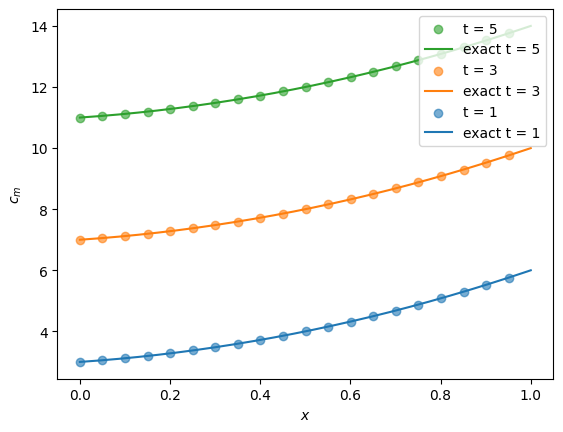

In [3]:
plot_times = [1, 3, 5]

for t in plot_times:
    x = solute_data["x"]
    y = solute_data[f"t{t:.2e}s".replace(".", "").replace("+", "")]
    # order y by x
    x, y = zip(*sorted(zip(x, y)))

    (l1,) = plt.plot(
        x,
        exact_solution_cm(np.array(x), t),
        label=f"exact t = {t}",
    )
    plt.scatter(
        x[::100],
        y[::100],
        label=f"t = {t}",
        color=l1.get_color(),
        alpha=0.6,
    )

    print(
        f"L2 error for cm at t = {t}: {norm(np.array(x), np.array(y), exact_solution_cm(x=np.array(x), t=t))}"
    )

plt.legend(reverse=True)
plt.ylabel("$c_m$")
plt.xlabel("$x$")
plt.show()

L2 error for cs: 4.285475874092749e-05


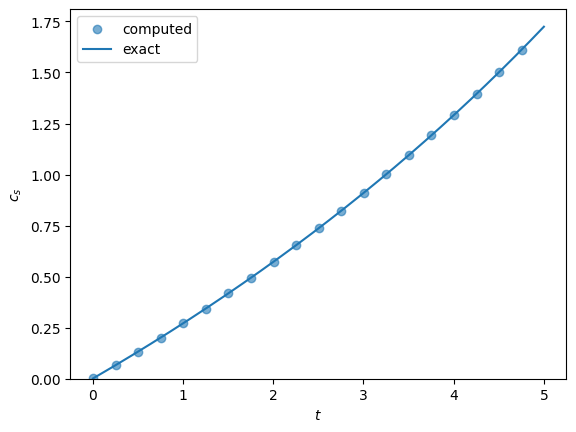

In [4]:
c_s_computed = adsorbed_data[0].data
t = adsorbed_data[0].t

print(f"L2 error for cs: {norm(t, c_s_computed, exact_solution_cs(t=np.array(t)))}")

plt.figure()

plt.scatter(t[::50], c_s_computed[::50], label="computed", alpha=0.6)
plt.plot(t, exact_solution_cs(np.array(t)), label="exact")
plt.ylabel("$c_s$")
plt.xlabel("$t$")
plt.legend()
plt.ylim(bottom=0)
plt.show()

# Paper-quality figure

/home/vvkulagin/anaconda3/envs/festim-env/lib/python3.11/site-packages/pypalettes/utils.py:5: DeprecationWarning: open_binary is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  with resources.open_binary('pypalettes', path) as f:


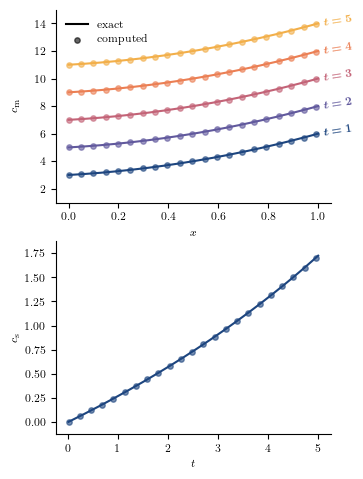

In [5]:
import matplotlib.pyplot as plt
from pypalettes import load_cmap

cmap = load_cmap("Sunset2", reverse=False)

params = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [
            r"\usepackage{bm}",
            r"\usepackage{siunitx}",
            r"\sisetup{detect-all}",
        ]
    ),
    "font.size": 8,
    "font.family": "Times New Roman",
}
plt.rcParams.update(params)

mm2inch = 0.1 / 2.54
fig, axs = plt.subplots(2, 1, figsize=(90 * mm2inch, 140 * mm2inch))

plot_times = [1, 2, 3, 4, 5]
for i, t in enumerate(plot_times):
    x = solute_data["x"]
    y = solute_data[f"t{t:.2e}s".replace(".", "").replace("+", "")]
    # order y by x
    x, y = zip(*sorted(zip(x, y)))

    axs[0].plot(x, exact_solution_cm(np.array(x), t), color=cmap(i), lw=1.5)

    axs[0].text(
        1.02,
        exact_solution_cm(1.04, t),
        rf"$\bm{{t={t}}}$",
        ha="left",
        va="center",
        rotation=9,
        color=cmap(i),
    )

    axs[0].scatter(
        x[::99],
        y[::99],
        s=15,
        color=cmap(i),
        alpha=0.6,
    )


c_s_computed = adsorbed_data[0].data
t = adsorbed_data[0].t

axs[0].plot(0, 0, color="black", lw=1.5, label="exact")
axs[0].scatter(0, 0, color="black", s=15, alpha=0.6, label="computed")
axs[0].legend(loc="upper left", frameon=False)
axs[0].set_ylabel(r"$c_\mathrm{m}$")
axs[0].set_xlabel("$x$")
axs[0].set_ylim(1, 15)

axs[1].scatter(
    t[::45], c_s_computed[::45], label="computed", alpha=0.6, s=15, color=cmap(0)
)
axs[1].plot(t, exact_solution_cs(np.array(t)), label="exact", color=cmap(0), lw=1.5)
axs[1].set_ylabel(r"$c_\mathrm{s}$")
axs[1].set_xlabel("$t$")
axs[1].set_ylim(-0.125, 1.75 + 0.125)


for axis in axs:
    axis.spines[["right", "top"]].set_visible(False)

fig.align_ylabels()

# plt.savefig("./MMS.png", dpi=1000, bbox_inches="tight", pad_inches=0.01)
plt.show()

# L2-error for solute H (uncomment to run)

In [3]:
def norm(x, c_comp, c_ex):
    return np.sqrt(np.trapz(y=(c_comp - c_ex) ** 2, x=x))


export_times = None
adsorbed_data = run_sim(export_times)
solute_data = np.loadtxt("mobile_conc.txt", skiprows=1, delimiter=",")

times = np.linspace(5e-3, 5, num=1000, endpoint=True)

ints = []
for i, t in enumerate(times):
    x = solute_data[:, 0]
    y = solute_data[:, i + 1]
    x, y = zip(*sorted(zip(x, y)))

    y = y - exact_solution_cm(x=np.array(x), t=t)
    ints.append(np.trapz(y**2, x=np.array(x)))

L2 = np.sqrt(np.trapz(np.array(ints), x=times))

print(f"L2 error for cm over domain Omega: {L2}")

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/vvkulagin/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        5.0e+00 s    Elapsed time so far: 1155.3 s
L2 error for cm at over domain Omega: 2.3313392135250146e-05
